In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech import Poincare
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def eq_mass_eigen(seed, P12, P3, etilde, mu, inc):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    reb_add_from_elements(m=mu*10, elements={'P':P3}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['R'] @ secsim['M'] @ secsim['R'].T
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    # initialize in ecom eigenmode
    A = [0,1,0]
    v1 = T @ A
    v1 /= np.linalg.norm(v1)
    z1 = secsim['S'] @ secsim['R'].T @ v1
    v = 1/abs(z1[1]-z1[0])*v1#v0 - v0[0]/v1[0]*v1
    zstar = secsim['S'] @ secsim['R'].T @ v
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi, 'inc':inc, 'Omega':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi, 'inc':inc, 'Omega':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu*10, elements={'P':P3,'e':abs(zstar[2])*e, 'pomega':np.arccos(np.sign(zstar[2])), 'M':np.random.random()*2*np.pi, 'inc':inc, 'Omega':np.random.random()*2*np.pi}, sim=sim)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    minTperi = ps[1].P*(1-ps[1].e)**1.5/(1+ps[1].e)**0.5
    sim.dt = minTperi/20
    
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_eigen(params): # collision: megno = 10000, lyap = 1/10, megno nan: megno = 1000, lyap = 1/20
    seed, P12, P3, etilde, mu, inc, tmax = params
    sim = eq_mass_eigen(seed, P12, P3, etilde, mu, inc)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = 3*Tsec[1] # take the middle eigenvalue corresponding to the ecom_12 DOF
    sim.init_megno()
    ps = sim.particles
    
    ec = 1 - P12**(2/3)
    e = etilde*ec
    
    Nsamp = 300
    times = np.linspace(0, tmax, Nsamp)
    res = {}
    res['e'] = np.array([np.zeros(Nsamp), np.zeros(Nsamp), np.zeros(Nsamp)])
    res['pomega'] = np.array([np.zeros(Nsamp), np.zeros(Nsamp), np.zeros(Nsamp)])
    megno = 0
    lyap = 0
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except:
            megno = 10000
            lyap = 1/10
            break
        res['e'][0, i] = ps[1].e
        res['e'][1, i] = ps[2].e
        res['e'][2, i] = ps[3].e
        res['pomega'][0, i] = ps[1].pomega
        res['pomega'][1, i] = ps[2].pomega
        res['pomega'][2, i] = ps[3].pomega

    mask = res['e'][0,:] > 0
    e1 = res['e'][0][mask]
    e2 = res['e'][1][mask]
    e3 = res['e'][2][mask]
    po1 = res['pomega'][0][mask]
    po2 = res['pomega'][1][mask]
    po3 = res['pomega'][2][mask]
    
    emx12 = e2*np.cos(po2)-e1*np.cos(po1)
    emy12 = e2*np.sin(po2)-e1*np.sin(po1)
    em12 = np.sqrt(emx12**2 + emy12**2)
    emx23 = e3*np.cos(po3)-e2*np.cos(po2)
    emy23 = e3*np.sin(po3)-e2*np.sin(po2)
    em23 = np.sqrt(emx23**2 + emy23**2)
    
    if e == 0:
        f12 = 1
        f23 = 1
    else:
        f12 = np.max(em12/e)
        f23 = np.max(em23/e)
    
    if megno == 0:
        megno = sim.calculate_megno()
        lyap = sim.calculate_lyapunov()
        if np.isnan(megno):
            megno = 1000
            lyap = 1/20
            
    return megno, lyap, f12, f23

In [3]:
def get_pool_params(xlist, ylist, P3, mu=1e-4, inc=0.1, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, P3, y, mu, inc, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False

In [4]:
inc=0.1
mu=1e-4
etildemax=0.8
P3 = 3.2
tmax = None

Pmin = 2/3
Pmax = 3/4
NPs = 480
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [5]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, inc=inc, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('single_eigenmode_inc0.1.npy', results)

CPU times: user 5.86 s, sys: 3.23 s, total: 9.09 s
Wall time: 47min 13s


In [6]:
inc=0.03
mu=1e-4
etildemax=0.8
P3 = 3.2
tmax = None

Pmin = 2/3
Pmax = 3/4
NPs = 480
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [7]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, inc=inc, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('single_eigenmode_inc0.03.npy', results)

CPU times: user 12.9 s, sys: 11 s, total: 23.9 s
Wall time: 56min 4s


In [8]:
inc=0.01
mu=1e-4
etildemax=0.8
P3 = 3.2
tmax = None

Pmin = 2/3
Pmax = 3/4
NPs = 480
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [9]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, inc=inc, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('single_eigenmode_inc0.01.npy', results)

CPU times: user 20.2 s, sys: 29.2 s, total: 49.4 s
Wall time: 56min 5s


In [17]:
res = np.load('single_eigenmode_inc0.01.npy')

res.shape

(76800, 4)

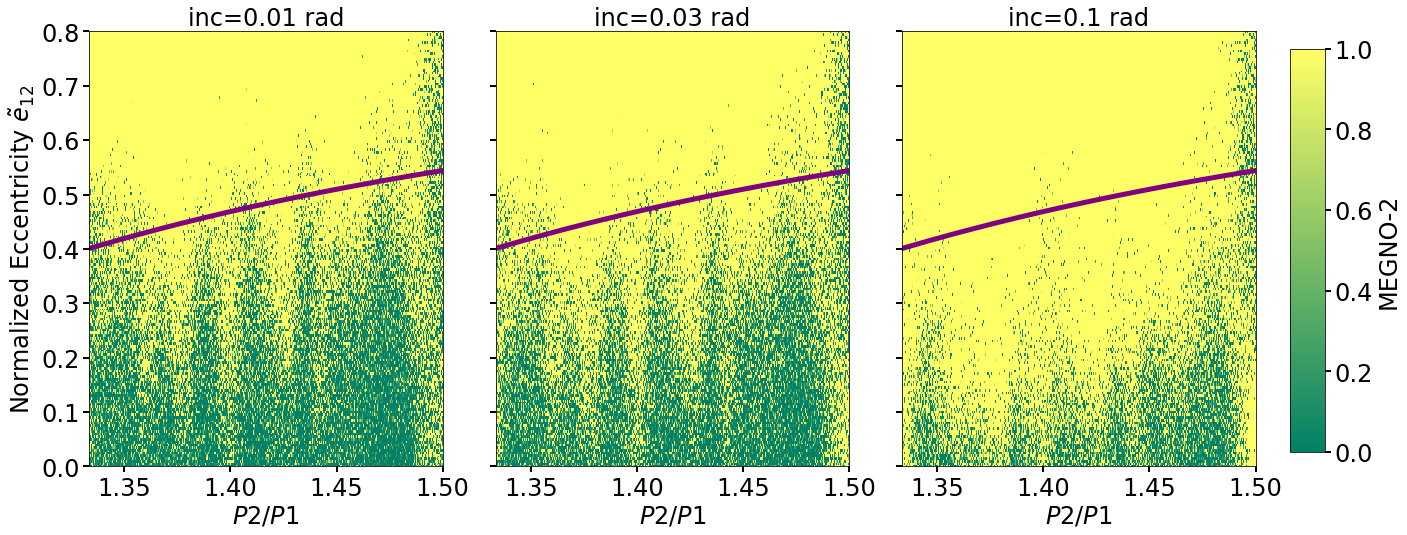

In [24]:
plt.style.use('paper')
fig, axarr = plt.subplots(figsize=(24,8), ncols=3, sharey=True)

ax = axarr[0]

inc=0.01
mu=1e-4
etildemax=0.8
P3 = 3.2

Pmin = 2/3
Pmax = 3/4
NPs = 480
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
res = np.load('single_eigenmode_inc0.01.npy')
megno = res[:,0]

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='H18')

ax.set_xlim([(1/P12s).min(), (1/P12s).max()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'Normalized Eccentricity $\tilde{e}_{\rm{12}}}$', fontsize=24)
ax.set_xlabel(r"$P2/P1$", fontsize=24)
ax.set_title(r"inc=0.01 rad", fontsize=24)

ax = axarr[1]

res = np.load('single_eigenmode_inc0.03.npy')
megno = res[:,0]

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='H18')

ax.set_xlim([(1/P12s).min(), (1/P12s).max()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_xlabel(r"$P2/P1$", fontsize=24)
ax.set_title(r"inc=0.03 rad", fontsize=24)

ax = axarr[2]

res = np.load('single_eigenmode_inc0.1.npy')
megno = res[:,0]

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='H18')

ax.set_xlim([(1/P12s).min(), (1/P12s).max()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_xlabel(r"$P2/P1$", fontsize=24)
ax.set_title(r"inc=0.1 rad", fontsize=24)

fig.subplots_adjust(right=0.8, wspace=0.15)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)
cb.ax.tick_params(labelsize=24)

for ax in axarr:
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    
fig.savefig('inclinations.pdf')